In [53]:
import torch
import os
import pandas as pd
import numpy as np
from utils.config import config_dataset
from utils.helper import ObjectView
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from utils.utils_gan_wasserstein import Discriminator_wassertein, Generator_linear, plot_GAN_loss, fit_gan_wasserstein, build_gan_scenarios
from utils.utils_vae import *

# Set the torch seed for result reproducibility
torch_seed = 3307
torch.manual_seed(torch_seed)

In [54]:
indices = []
non_null_indexes = list(np.delete(np.asarray([i for i in range(96)]), indices))
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

X_train = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/X_train.pt", weights_only=True)
X_test = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/X_test.pt", weights_only=True)
cond_train = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/cond_train.pt", weights_only=True)
cond_test = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/cond_test.pt", weights_only=True)
PV_base_train = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/PV_base_train.pt", weights_only=True)
PV_base_test = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/PV_base_test.pt", weights_only=True)

print(X_train.shape)
print(X_test.shape)
print(cond_train.shape)
print(cond_test.shape)
print(PV_base_train.shape)
print(PV_base_test.shape)

X_train = (X_train + 1) / 2
X_test = (X_test + 1) / 2
X_train, X_val, cond_train, cond_val = train_test_split(X_train, cond_train, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, cond_train.shape, cond_test.shape, X_val.shape, cond_val.shape

y_LS_scaler = StandardScaler()
y_LS_scaler.fit(X_train)
y_LS_scaled = y_LS_scaler.transform(X_train)
y_VS_scaled = y_LS_scaler.transform(X_val)
y_TEST_scaled = y_LS_scaler.transform(X_test)

x_LS_scaler = StandardScaler()
x_LS_scaler.fit(cond_train)
x_LS_scaled = x_LS_scaler.transform(cond_train)
x_VS_scaled = x_LS_scaler.transform(cond_val)
x_TEST_scaled = x_LS_scaler.transform(cond_test)

torch.Size([8760, 96])
torch.Size([2190, 96])
torch.Size([8760, 79])
torch.Size([2190, 79])
torch.Size([8760, 7, 96])
torch.Size([2190, 7, 96])


In [55]:
# n_s = 100 # num of samples
n_s = 20
N_q = 96
# semble un bon set de hp mais d'un calcul a l'autre les résultats changent bcp ...
nb_epoch = 500

cf_VAE = {
    'name': 'VAElinear_1',
    'latent_s': 5,
    'enc_w': 500,
    'enc_l': 1,
    'dec_w': 500,
    'dec_l': 1,
    'weight_decay': 10 ** (-4),
    'learning_rate': 10 ** (-3.9),
}

print('VAE latent_s %s enc_w %s enc_l %s dec_w %s dec_l %s weight_decay %.4e lr %.4e' % (cf_VAE['latent_s'], cf_VAE['enc_w'], cf_VAE['enc_l'], cf_VAE['dec_w'], cf_VAE['dec_l'], cf_VAE['weight_decay'], cf_VAE['learning_rate']))


VAE latent_s 5 enc_w 500 enc_l 1 dec_w 500 dec_l 1 weight_decay 1.0000e-04 lr 1.2589e-04


In [56]:
# Set the VAE configuration
config = cf_VAE
tag = "load"

# --------------------------------------------------------------------------------------------------------------
# Build the VAE
# --------------------------------------------------------------------------------------------------------------

config['in_size'] = y_LS_scaled.shape[1]
config['cond_in'] = x_LS_scaled.shape[1]


VAE_model = VAElinear(latent_s=config['latent_s'], cond_in=config['cond_in'], in_size=config['in_size'], enc_w=config['enc_w'], enc_l=config['enc_l'], dec_w=config['dec_w'], dec_l=config['dec_l'], gpu=True)
opt = torch.optim.Adam(VAE_model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

In [57]:
# --------------------------------------------------------------------------------------------------------------
# Fit the VAE
# --------------------------------------------------------------------------------------------------------------
print('Fit VAE with %s epochs' % (nb_epoch))
training_time = 0.
start = timer()
loss, best_vae, last_vae = fit_VAE(nb_epoch=nb_epoch, x_LS=x_LS_scaled, y_LS=y_LS_scaled, x_VS=x_VS_scaled,
                                    y_VS=y_VS_scaled, x_TEST=x_TEST_scaled, y_TEST=y_TEST_scaled,
                                    model=VAE_model,
                                    opt=opt, gpu=True)
end = timer()
training_time += end - start
print('Training time %.2f s' %(training_time))
epoch_min = np.nanargmin(loss[:, 1])
print('epoch %s ll VS is min = %.2f ll TEST = %.2f' % (epoch_min, loss[epoch_min, 1], loss[epoch_min, 2]))


Fit VAE with 500 epochs
Fitting time_tot 0 mintime left : 0.002991 min - LS loss: 23.901906 VS loss: 28.013567 TEST loss: 26.527157
Training time 9.98 s
epoch 498 ll VS is min = 27.98 ll TEST = 26.52


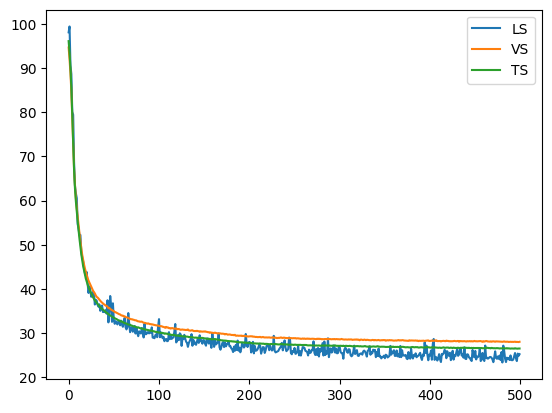

In [58]:
plt.figure()
plt.plot(loss[:, 0], label='LS')
plt.plot(loss[:, 1], label='VS')
plt.plot(loss[:, 2], label='TS')
plt.legend()

In [59]:
# --------------------------------------------------------------------------------------------------------------
# Build scenarios on VS & TEST
# --------------------------------------------------------------------------------------------------------------

# best_flow = read_file(dir=dir_path, name=name)
max_power = 1
# Scenarios are generated into a dict of length nb days (#VS or # TEST sizes)
# Each day of the dict is an array of shape (n_scenarios, 24)
generation_time = 0.
start = timer()
    # s_LS = build_vae_scenarios(n_s=n_s, x=x_LS_scaled, y_scaler=y_LS_scaler, model=best_vae, max=max_power, gpu=gpu, tag=tag, non_null_indexes=non_null_indexes)
s_TEST = build_vae_scenarios(n_s=n_s, x=x_TEST_scaled, y_scaler=y_LS_scaler, model=best_vae, max=max_power, gpu=True, tag=tag, non_null_indexes=non_null_indexes)
s_VS = build_vae_scenarios(n_s=n_s, x=x_VS_scaled, y_scaler=y_LS_scaler, model=best_vae, max=max_power, gpu=True, tag=tag, non_null_indexes=non_null_indexes)
end = timer()
generation_time += end - start
print('Generation time (LS, VS, TEST) %.2f s' %(generation_time))

Scenario generation time_tot 0.0 min00000 min


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [60]:
X_test_hat = s_TEST.reshape(-1, 96, s_TEST.shape[-1])
X_test_hat = torch.tensor(X_test_hat).permute(0, 2, 1)

In [61]:
X_test_hat = X_test_hat * 2 - 1
X_test = X_test * 2 - 1
X_test_hat.shape

torch.Size([2190, 20, 96])

In [62]:
num_class = config_dataset["num_class"]

def denorm(x):
    loads = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/loads_raw.pt")
    lmin = []
    lmax = []
    for i in range(loads.shape[0]):
        load = loads[i]
        lmin.append(load.min())
        lmax.append(load.max())
    lmin = torch.stack(lmin)[:num_class]
    lmax = torch.stack(lmax)[:num_class]
    lmin = lmin.unsqueeze(1).repeat(1, int(x.shape[0]/num_class))
    lmax = lmax.unsqueeze(1).repeat(1, int(x.shape[0]/num_class))
    lmin = lmin.reshape((-1, 1, 1))
    lmax = lmax.reshape((-1, 1, 1))
    return (x + 1)* (lmax - lmin) / 2 + lmin

In [63]:
torch.save(denorm(X_test_hat), "../result/data/pecan/load_hat_vae.pt")

/tmp/ipykernel_42141/2212657966.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loads = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/loads_raw.pt")

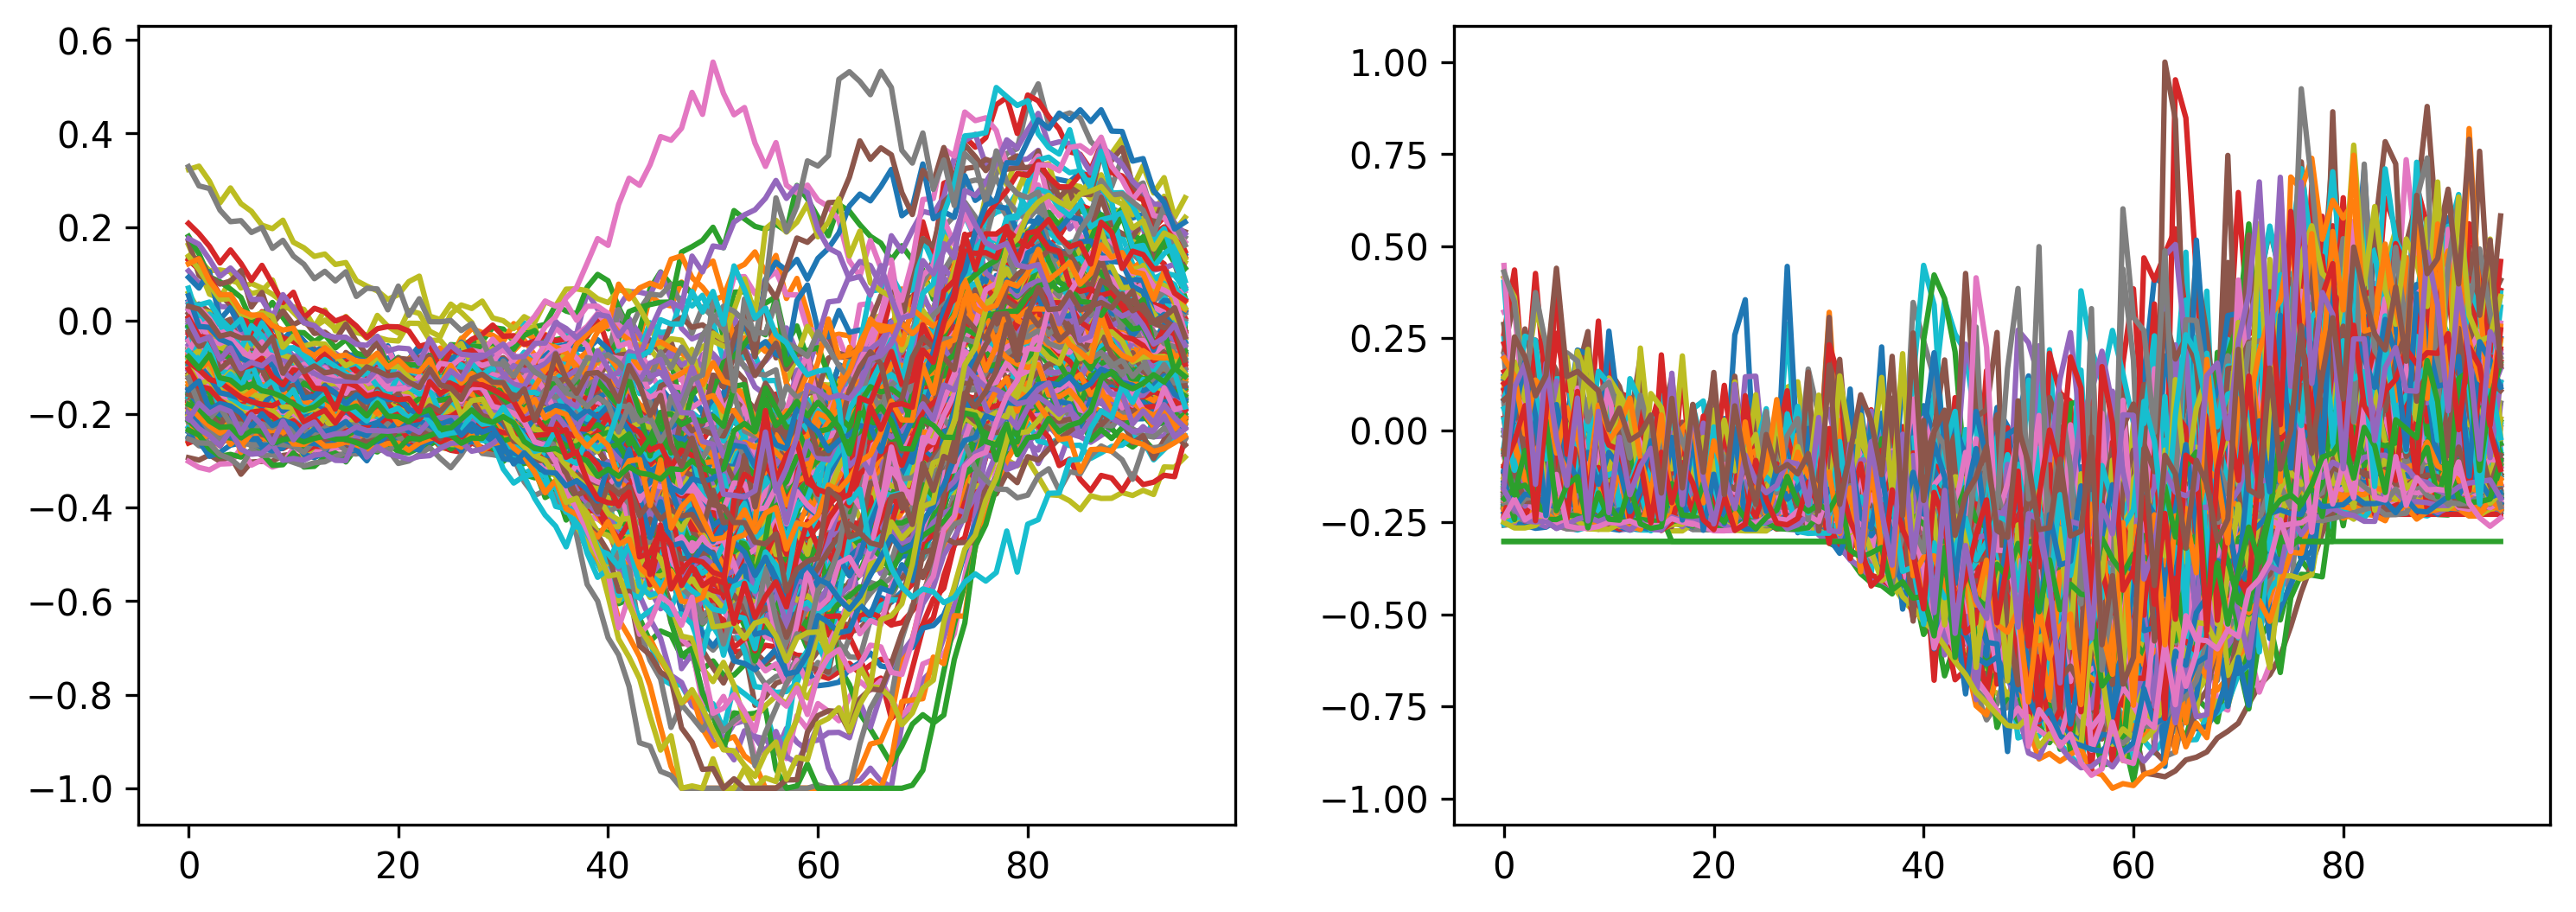

In [64]:
user = 0
plt.figure(figsize=(12,4), dpi=300)
plt.subplot(1,2,1)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test_hat[i, 0, :])
plt.subplot(1,2,2)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test[i])

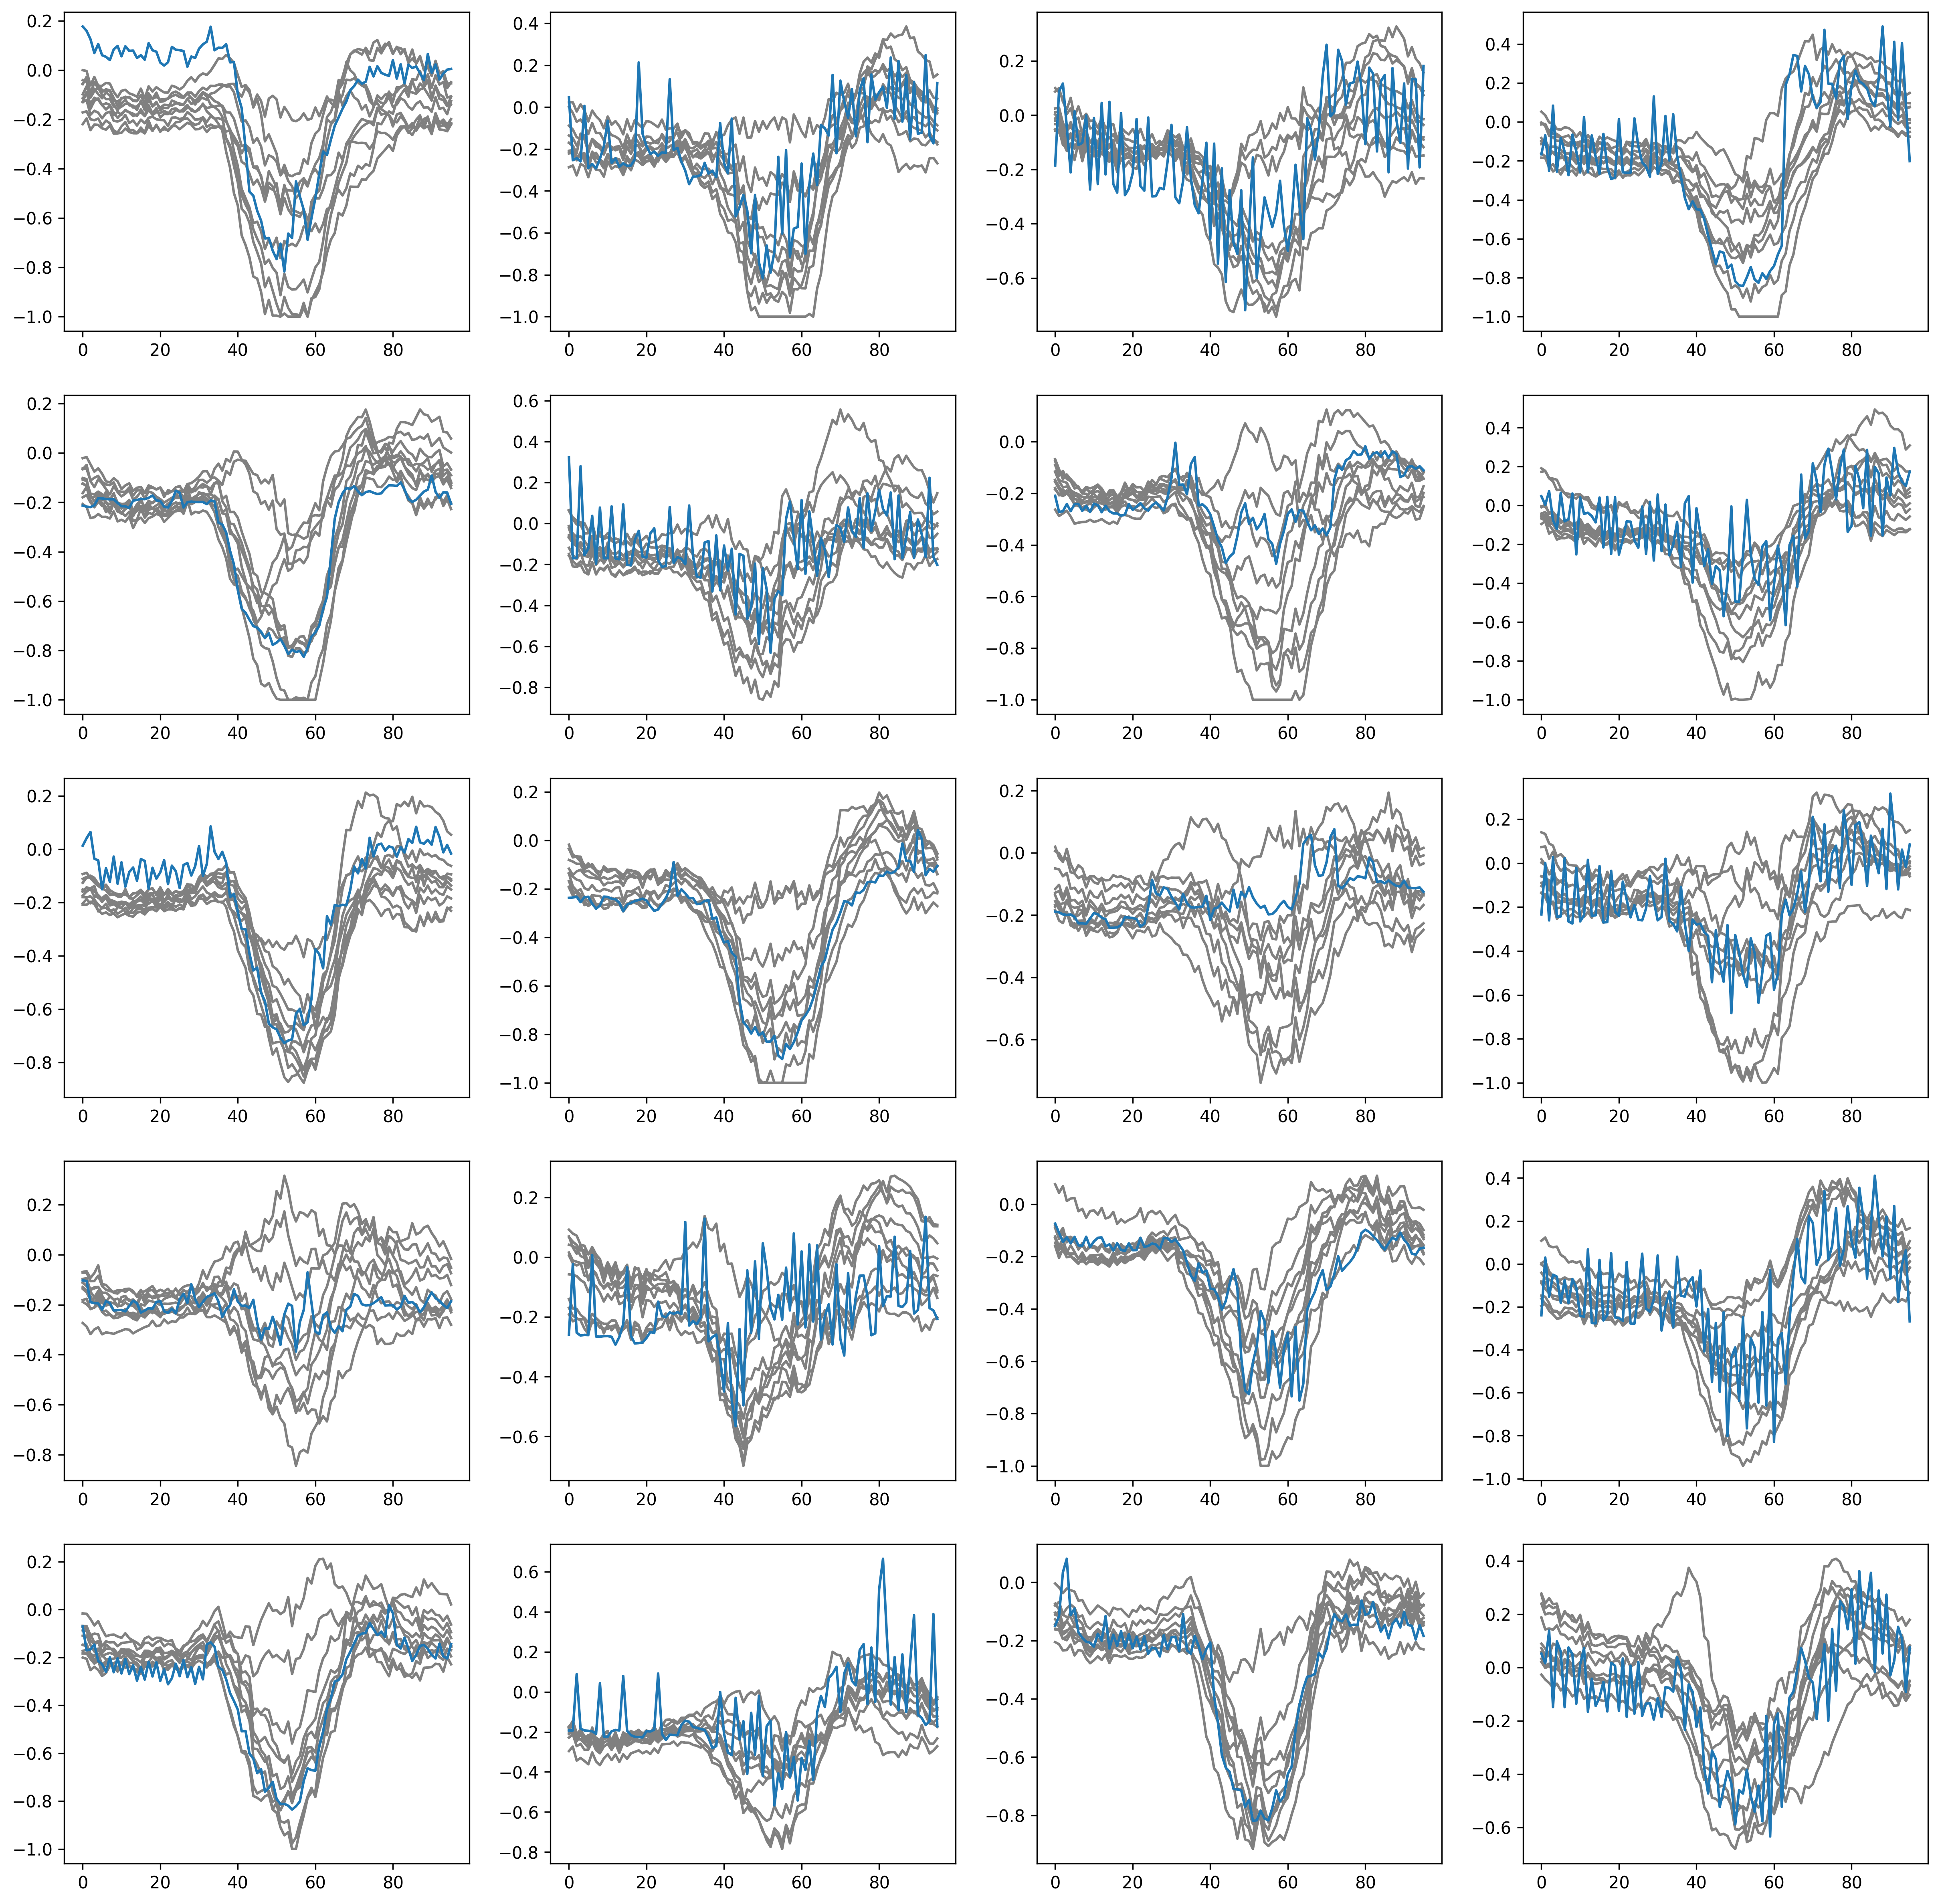

In [65]:
n = 20
plt.figure(figsize=(20,20), dpi=300)
for j in range(n):
    plt.subplot(int(n/4), 4, j+1)
    j = j + 200
    for i in range(10):
        plt.plot(X_test_hat[j][i], color='gray')
    plt.plot(X_test[j])